<a href="https://colab.research.google.com/github/minhyoung0724/great-ecg/blob/main/MinhyoungNa_Classifier_Update_022421_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE) for the Electrocardiogram (ECG) Generation

# Libraries

In [1]:
pip install wfdb

     |████████████████████████████████| 133kB 14.1MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import datetime
import itertools
import copy

import wfdb

import torch
import torch.nn as nn
from torch.utils.data import  TensorDataset, DataLoader
import torch.nn.functional as F

In [3]:
plt.rcParams['font.size']   = 12
axisFontSize  = 14
titleFontSize = 20

# Parameters

In [4]:
dataName   = 'afdb'
resultPath = './result'
dataPath   = './data'
dataLen    = 200

bs = 64
data_using = 100000

In [5]:
if dataName not in dict(wfdb.get_dbs()).keys():
    for i in range(100):
        print('[ERROR] Invalid data name!!')

Make the folder

In [6]:
def makeFolder(path, folderName):
    folders = path.split('/')
    path    = folders[0]
    for folder in folders[1:]:
        path += '/' + folder
        if not os.path.isdir(path):
            os.mkdir(path)
    
    folder = path + '/' + folderName
    if not os.path.isdir(folder):
        os.mkdir(folder)
    return folder

resultFolder = makeFolder(resultPath, datetime.datetime.now().strftime("%y%m%d_%H%M%S"))
dataFolder   = makeFolder(dataPath,   dataName)

# Read the data

Download the data

In [7]:
print('Data name: {}'.format(dict(wfdb.get_dbs())[dataName]))
wfdb.dl_database(dataName, dataFolder)

Data name: MIT-BIH Atrial Fibrillation Database
Generating record list for: 00735
Generating record list for: 03665
Generating record list for: 04015
Generating record list for: 04043
Generating record list for: 04048
Generating record list for: 04126
Generating record list for: 04746
Generating record list for: 04908
Generating record list for: 04936
Generating record list for: 05091
Generating record list for: 05121
Generating record list for: 05261
Generating record list for: 06426
Generating record list for: 06453
Generating record list for: 06995
Generating record list for: 07162
Generating record list for: 07859
Generating record list for: 07879
Generating record list for: 07910
Generating record list for: 08215
Generating record list for: 08219
Generating record list for: 08378
Generating record list for: 08405
Generating record list for: 08434
Generating record list for: 08455
Generating list of all files for: 00735
Generating list of all files for: 03665
Generating list of all

Read the data

In [8]:
data = []
labels = []
classes = []

halfLen = dataLen // 2
label = 0

for fileName in wfdb.io.get_record_list(dataName):
    try:
        # Get the signal
        ECG   = wfdb.rdsamp(os.path.join(dataFolder, fileName))[0]
        peaks = wfdb.rdann(os.path.join(dataFolder, fileName), 'qrs').sample

        classes.append(fileName)
        
        # Parsing the data
        ECGlen = ECG.shape[0]
        print('Read: File [{}]'.format(fileName));

        for peak in peaks:
            if 0 <= peak-halfLen and peak+halfLen <= ECGlen:
              data.append(ECG[peak-halfLen:peak+halfLen, 0])
              data.append(ECG[peak-halfLen:peak+halfLen, 1])
              labels.append(label)
              labels.append(label)

        label += 1

    except Exception as e:
        print('Exception: File [{}] ({})'.format(fileName, e))
        
data = np.array(data)
data = data.astype(np.float32)
print(data)
print(data.shape)

classes = np.array(classes)
print(classes)
print(classes.shape)

labels = np.array(labels)
print(labels)
print(labels.shape)

Exception: File [00735] (sampto must be greater than sampfrom)
Exception: File [03665] (sampto must be greater than sampfrom)
Read: File [04015]
Read: File [04043]
Read: File [04048]
Read: File [04126]
Read: File [04746]
Read: File [04908]
Read: File [04936]
Read: File [05091]
Read: File [05121]
Read: File [05261]
Read: File [06426]
Read: File [06453]
Read: File [06995]
Read: File [07162]
Read: File [07859]
Read: File [07879]
Read: File [07910]
Read: File [08215]
Read: File [08219]
Read: File [08378]
Read: File [08405]
Read: File [08434]
Read: File [08455]
[[-0.61  -0.61  -0.645 ... -0.17  -0.19  -0.18 ]
 [-0.28  -0.29  -0.275 ... -0.225 -0.215 -0.23 ]
 [-0.615 -0.56  -0.5   ...  0.05   0.025  0.02 ]
 ...
 [ 0.24   0.255  0.14  ...  0.06   0.035  0.15 ]
 [-0.655  0.16  -0.905 ...  1.075 -0.295 -0.405]
 [-0.02   0.025  0.22  ...  0.265  0.43   0.375]]
(2257110, 200)
['04015' '04043' '04048' '04126' '04746' '04908' '04936' '05091' '05121'
 '05261' '06426' '06453' '06995' '07162' '07859' 

Normalize the data (data $\in \left[0, 1\right]$)

In [9]:
data = (data - data.min()) / (data.max() - data.min())

Visualize the data

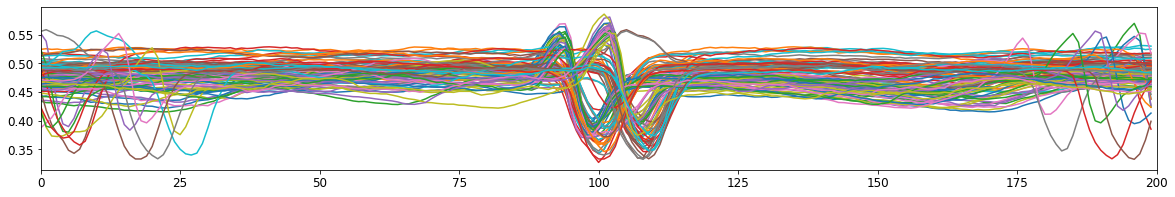

In [10]:
plt.figure(figsize=(20, 3))
plt.plot(data[:100].T)
plt.xlim(0, dataLen)
plt.show()

Shuffle data

In [11]:
idx = np.arange(data.shape[0])
np.random.shuffle(idx)

data = data[idx]
print ("data: ", data)
labels = labels[idx]
print ("labels: ", label)

data:  [[0.49835378 0.4977552  0.49985036 ... 0.49176896 0.4899731  0.4899731 ]
 [0.49476206 0.49446276 0.49685726 ... 0.5010476  0.49865308 0.49146962]
 [0.48937446 0.48937446 0.48937446 ... 0.49356478 0.49326548 0.49386412]
 ...
 [0.45585155 0.43789285 0.45884466 ... 0.4414846  0.46812332 0.47919786]
 [0.46064055 0.4594433  0.4612392  ... 0.4926669  0.49476206 0.49565998]
 [0.477402   0.4780006  0.477402   ... 0.48099372 0.48069438 0.48159236]]
labels:  23


In [12]:
train_x = torch.tensor(data[:data_using - data_using // 10])
train_y = torch.tensor(labels[:data_using - data_using // 10])
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_x = torch.tensor(data[data_using - data_using // 10:])
test_y = torch.tensor(labels[data_using - data_using // 10:])
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

Build a classifier 

In [ ]:
#Avg pooling
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
    self.fc4 = nn.Linear(6*64 , 128)
    self.fc5 = nn.Linear(128, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.avg_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3)
    h = F.avg_pool1d(F.relu(self.conv2(h)), 3)
    h = F.avg_pool1d(F.relu(self.conv3(h)), 3)
    h = h.view(-1, 6*64)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    #h = h.squeeze()
    return h

In [ ]:
#Bigger Architecture 4conv 5fc
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2) #199
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2) #98
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2) #48
    self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2) #23
    self.fc5 = nn.Linear(11*128 , 640)
    self.fc6 = nn.Linear(640, 320)
    self.fc7 = nn.Linear(320, 160)
    self.fc8 = nn.Linear(160, 80)
    self.fc9 = nn.Linear(80, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 2) #99
    h = F.max_pool1d(F.relu(self.conv2(h)), 2) #49
    h = F.max_pool1d(F.relu(self.conv3(h)), 2) #24
    h = F.max_pool1d(F.relu(self.conv4(h)), 2) #11
    h = h.view(-1, 11*128)
    h = self.dropout(self.fc5(h))
    h = self.dropout(self.fc6(h))
    h = self.dropout(self.fc7(h))
    h = self.dropout(self.fc8(h))
    h = self.dropout(self.fc9(h))
    #h = h.squeeze()
    return h

In [ ]:
#Bigger_more fc
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
    self.fc4 = nn.Linear(6*64 , 3*64)
    self.fc5 = nn.Linear(3*64, 3*32)
    self.fc6 = nn.Linear(3*32, 3*16)
    self.fc7 = nn.Linear(3*16, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3)
    h = F.max_pool1d(F.relu(self.conv2(h)), 3)
    h = F.max_pool1d(F.relu(self.conv3(h)), 3)
    h = h.view(-1, 6*64)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    h = self.dropout(self.fc6(h))
    h = self.dropout(self.fc7(h))
    #h = h.squeeze()
    return h

In [ ]:
#Less_1 (less channel)
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3)
    self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3)
    self.conv3 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3)
    self.fc4 = nn.Linear(6*16 , 3*16)
    self.fc5 = nn.Linear(3*16, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3)
    h = F.max_pool1d(F.relu(self.conv2(h)), 3)
    h = F.max_pool1d(F.relu(self.conv3(h)), 3)
    h = h.view(-1, 6*16)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    #h = h.squeeze()
    return h

In [ ]:
#More channel
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
    self.fc4 = nn.Linear(6*128 , 128)
    self.fc5 = nn.Linear(128, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3)
    h = F.max_pool1d(F.relu(self.conv2(h)), 3)
    h = F.max_pool1d(F.relu(self.conv3(h)), 3)
    h = h.view(-1, 6*128)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    #h = h.squeeze()
    return h

In [ ]:
#More channel, More FC
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
    self.fc4 = nn.Linear(6*128 , 6*128)
    self.fc5 = nn.Linear(6*128 , 3*128)
    self.fc6 = nn.Linear(3*128 , 3*128)
    self.fc7 = nn.Linear(3*128 , 3*64)
    self.fc8 = nn.Linear(3*64 , 3*64)
    self.fc9 = nn.Linear(3*64, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3)
    h = F.max_pool1d(F.relu(self.conv2(h)), 3)
    h = F.max_pool1d(F.relu(self.conv3(h)), 3)
    h = h.view(-1, 6*128)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    h = self.dropout(self.fc6(h))
    h = self.dropout(self.fc7(h))
    h = self.dropout(self.fc8(h))
    h = self.dropout(self.fc9(h))
    #h = h.squeeze()
    return h

In [ ]:
#More channel, 0.0001
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
    self.fc4 = nn.Linear(6*128 , 128)
    self.fc5 = nn.Linear(128, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3)
    h = F.max_pool1d(F.relu(self.conv2(h)), 3)
    h = F.max_pool1d(F.relu(self.conv3(h)), 3)
    h = h.view(-1, 6*128)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    #h = h.squeeze()
    return h

classifier = Classifier()

if torch.cuda.is_available():
  classifier.cuda()

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

In [ ]:
#More channel, 0.005
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
    self.fc4 = nn.Linear(6*128 , 128)
    self.fc5 = nn.Linear(128, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3)
    h = F.max_pool1d(F.relu(self.conv2(h)), 3)
    h = F.max_pool1d(F.relu(self.conv3(h)), 3)
    h = h.view(-1, 6*128)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    #h = h.squeeze()
    return h

classifier = Classifier()

if torch.cuda.is_available():
  classifier.cuda()

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.005)
loss_function = nn.CrossEntropyLoss()

In [ ]:
#More channel, bigger kernel
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=6) #195
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=6) #60
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=6) #15
    self.fc4 = nn.Linear(5*128 , 128)
    self.fc5 = nn.Linear(128, len(classes))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    h = F.max_pool1d(F.relu(self.conv1(x.unsqueeze(1))), 3) #65
    h = F.max_pool1d(F.relu(self.conv2(h)), 3) #20
    h = F.max_pool1d(F.relu(self.conv3(h)), 3) #5
    h = h.view(-1, 5*128)
    h = self.dropout(self.fc4(h))
    h = self.dropout(self.fc5(h))
    #h = h.squeeze()
    return h

In [13]:
#More channel, bigger kernel
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=6) #195
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=6) #195
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=6) #60
    self.conv4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=6) #60
    self.conv5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=6) #60
    self.conv6 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=6) #15
    self.fc7 = nn.Linear(6*128 , 128)
    self.fc8 = nn.Linear(128, len(classes))
    self.dropout = nn.Dropout(p=0.25)

  def forward(self, x):
    h = F.relu(self.conv1(x.unsqueeze(1))) #195
    h = F.max_pool1d(F.relu(self.conv2(h)), 2) #190, 95
    h = F.relu(self.conv3(h)) #90
    h = F.max_pool1d(F.relu(self.conv4(h)), 3) #85, 28
    h = F.relu(self.conv5(h)) #23
    h = F.max_pool1d(F.relu(self.conv6(h)), 3) #18, 6
    h = h.view(-1, 6*128)
    h = self.dropout(self.fc7(h))
    h = self.dropout(self.fc8(h))
    #h = h.squeeze()
    return h

In [14]:
classifier = Classifier()

if torch.cuda.is_available():
  classifier.cuda()

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [15]:
average_loss = []
accuracy = []

Train & Test

In [16]:
def train(epoch):
  classifier.train()
  train_loss = 0
  for batch_idx, (data_x, data_y) in enumerate(train_loader):
    data_x = data_x.cuda()
    data_y = data_y.cuda()

    optimizer.zero_grad()

    output = classifier(data_x)
    output = output.float()

    loss = loss_function(output, data_y)
    loss.backward()
    train_loss += loss.item()
    
    optimizer.step()
    
    if batch_idx % 100 == 0:
      #print(data_x)
      #print(output)
      #print(data_y)
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data_x), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item() / len(data_x)))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
  average_loss.append(train_loss / len(train_loader.dataset))

In [17]:
def test():
  classifier.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data_x, data_y in test_loader:
      data_x = data_x.cuda()
      data_y = data_y.cuda()
      
      output = classifier(data_x)
      output = output.float()

      _, predicted = torch.max(output.data, 1)
      total += len(data_y)
      correct += (predicted == data_y).sum().item()
    
  print('====> Accuracy: {:.4f}'.format((correct / total * 100)))
  accuracy.append(correct / total * 100)

In [18]:
for epoch in range(0, 25):
  train(epoch)
  test()

Train Epoch: 0 [0/90000 (0%)]	Loss: 0.049105
Train Epoch: 0 [6400/90000 (7%)]	Loss: 0.049482
Train Epoch: 0 [12800/90000 (14%)]	Loss: 0.045012
Train Epoch: 0 [19200/90000 (21%)]	Loss: 0.034371
Train Epoch: 0 [25600/90000 (28%)]	Loss: 0.032264
Train Epoch: 0 [32000/90000 (36%)]	Loss: 0.024068
Train Epoch: 0 [38400/90000 (43%)]	Loss: 0.021802
Train Epoch: 0 [44800/90000 (50%)]	Loss: 0.021492
Train Epoch: 0 [51200/90000 (57%)]	Loss: 0.016001
Train Epoch: 0 [57600/90000 (64%)]	Loss: 0.019913
Train Epoch: 0 [64000/90000 (71%)]	Loss: 0.020771
Train Epoch: 0 [70400/90000 (78%)]	Loss: 0.015614
Train Epoch: 0 [76800/90000 (85%)]	Loss: 0.016882
Train Epoch: 0 [83200/90000 (92%)]	Loss: 0.018326
Train Epoch: 0 [89600/90000 (100%)]	Loss: 0.017881
====> Epoch: 0 Average loss: 0.0262
====> Accuracy: 87.6776
Train Epoch: 1 [0/90000 (0%)]	Loss: 0.015913
Train Epoch: 1 [6400/90000 (7%)]	Loss: 0.013040
Train Epoch: 1 [12800/90000 (14%)]	Loss: 0.012672
Train Epoch: 1 [19200/90000 (21%)]	Loss: 0.017068
Tra

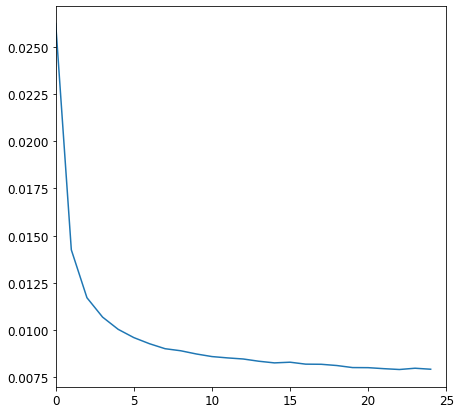

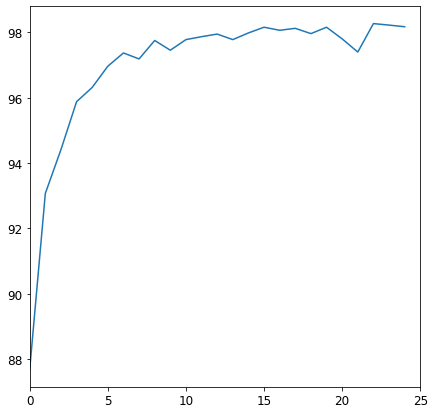

In [19]:
plt.figure(figsize=(7, 7))
plt.plot(average_loss)
plt.xlim(0, 25)
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(accuracy)
plt.xlim(0, 25)
plt.show()

Save & Load Model

In [22]:
torch.save(classifier.state_dict(), "./model.pt")

In [23]:
model = Classifier().cuda()
model.load_state_dict(torch.load("./model.pt")) 
model.eval()

total=0
correct=0

with torch.no_grad():
  for data_x, data_y in test_loader:
    data_x = data_x.cuda()
    data_y = data_y.cuda()
    
    output = model(data_x)
    output = output.float()

    _, predicted = torch.max(output.data, 1)
    total += len(data_y)
    correct += (predicted == data_y).sum().item()
  
print('====> Accuracy: {:.4f}'.format((correct / total * 100)))
accuracy.append(correct / total * 100)

====> Accuracy: 98.1697


Load Poisoned data

In [24]:
data_load = np.load("./poisoned_data.npy")
label_load = np.load("./poisoned_label.npy")

poison_x = torch.tensor(data_load)
poison_label = torch.tensor(label_load)
poison_dataset = TensorDataset(poison_x, poison_label)
poison_loader = DataLoader(poison_dataset, batch_size=1, shuffle=True)

total=0
correct=0

with torch.no_grad():
  for data_x, data_y in poison_loader:
    data_x = data_x.cuda()
    data_y = data_y.cuda()

    data_x = data_x.float()
    
    output = model(data_x)
    output = output.float()
    
    _, predicted = torch.max(output.data, 1)
    total += len(data_y)
    correct += (predicted == data_y).sum().item()
  
print('====> Accuracy: {:.4f}'.format((correct / total * 100)))
accuracy.append(correct / total * 100)

====> Accuracy: 5.3000
